In [1]:
from bs4 import BeautifulSoup
import requests
import os
from selenium import webdriver
import pandas as pd
import numpy as np
import time
from splinter import Browser
import webbrowser
import matplotlib.pyplot as plt

In [2]:
def scrape_genre(genre_column, genre_query):
    browser = Browser('chrome', executable_path="chromedriver", headless=False)
    top_songs_url = f"https://soundcloud.com/charts/top?genre={genre_query}&country=US"
    browser.visit(top_songs_url)

    # Scroll to 30 items
    time.sleep(2)
    browser.execute_script("window.scrollTo(0, document.body.scrollHeight);var lenOfPage=document.body.scrollHeight;return lenOfPage;")
    # Scroll to 40 items
    time.sleep(2)
    browser.execute_script("window.scrollTo(0, document.body.scrollHeight);var lenOfPage=document.body.scrollHeight;return lenOfPage;")
    # Scroll to 50 items
    time.sleep(2)
    browser.execute_script("window.scrollTo(0, document.body.scrollHeight);var lenOfPage=document.body.scrollHeight;return lenOfPage;")
    
    #import pdb; pdb.set_trace()
    html = browser.html
    soup = BeautifulSoup(html, 'html.parser')
    topChart = soup.find('div', class_='chartTracks lazyLoadingList')
    songs = topChart.find_all('li', class_='chartTracks__item')

    songNames = []
    chartPosition = []
    artists = []
    weeklyListenCount = []
    allTimeListenCount = []

    for song in songs:

        position = song.find('div',class_ = 'chartTrack__position sc-font-tabular')
        positionNumber = position.text.strip()
        chartPosition.append(positionNumber)

        trackDetails = song.find('div', class_ = 'chartTrack__details')
        artistName = song.find(class_='sc-link-light')
        names = artistName.text.strip()
        cleanedNames = names.replace('\x7f',"")
        artists.append(cleanedNames)

        weeklyPlayHiddenScore = song.find(class_='sc-visuallyhidden')
        if weeklyPlayHiddenScore:
            weeklyPlayAmount = weeklyPlayHiddenScore.text.strip()
            weeklyListenCount.append(weeklyPlayAmount)
        else:
            weeklyListenCount.append(0)

        songName = song.find(class_="sc-link-dark")
        nameText = songName.text.strip()
        songNames.append(nameText)

        allTimePlayHiddenScore = song.find(class_='chartTrack__scoreAllPlays')
        if allTimePlayHiddenScore:
            allPlayHiddenScore = allTimePlayHiddenScore.find(class_='sc-visuallyhidden')
            allPlayAmount = allPlayHiddenScore.text.strip()
            allTimeListenCount.append(allPlayAmount)
        else:
            allTimeListenCount.append(0)

    MusicDataFrame = pd.DataFrame(list(zip(chartPosition,songNames,artists,weeklyListenCount,allTimeListenCount)), 
                                                  columns=['Chart Position', 'Song Name', 'Artist', 'Weekly Play Count', 'All Time Play Count'])
    MusicDataFrame.set_index('Chart Position', inplace=True)
    MusicDataFrame['Genre'] = genre_column
    return MusicDataFrame

In [3]:
rockDataFrame = scrape_genre("Rock", "rock")
worldMusicDataFrame = scrape_genre("World Music", "all-music")
altRockDataFrame = scrape_genre("Alternative Rock", "alternativerock")
ambientDataFrame = scrape_genre("Ambient", "ambient")
classicalDataFrame = scrape_genre("Classical", "classical")
countryDataFrame = scrape_genre("Country", "country")
edmDataFrame = scrape_genre("Electronic Dance Music (EDM)", "danceedm")
danceHallDataFrame = scrape_genre("Dance Hall", "dancehall")
deepHouseDataFrame = scrape_genre("Deep House", "deephouse")
discoDataFrame = scrape_genre("Disco", "disco")
drumBassDataFrame = scrape_genre("Drum Bass", "drumbass")
dubStepDataFrame = scrape_genre("Dubstep", "dubstep")
electronicDataFrame = scrape_genre("Electronic", "electronic")
folkDataFrame = scrape_genre("Folk", "folksingersongwriter")
hipHopDataFrame = scrape_genre("Hip-Hop", "hiphoprap")
houseDataFrame = scrape_genre("House", "house")
indieDataFrame = scrape_genre("Indie", "indie")
jazzDataFrame = scrape_genre("Jazz", "jazzblues")
latinDataFrame = scrape_genre("Latin", "latin")
metalDataFrame = scrape_genre("Metal", "metal")
pianoDataFrame = scrape_genre("Piano", "piano")
popDataFrame = scrape_genre("Pop", "pop")
rnbDataFrame = scrape_genre("R&B", "rbsoul")
reggaeDataFrame = scrape_genre("Reggae", "reggae")
reggaetonDataFrame = scrape_genre("Reggaeton", "reggaeton")
soundtrackDataFrame = scrape_genre("SoundTrack", "soundtrack")
technoDataFrame = scrape_genre("Techno", "techno")
worldDataFrame = scrape_genre("World Music", "world")

In [5]:
df_final_combined = pd.concat([altRockDataFrame, ambientDataFrame, rockDataFrame, danceHallDataFrame,
                    classicalDataFrame, countryDataFrame, edmDataFrame, deepHouseDataFrame, 
                    discoDataFrame, drumBassDataFrame, dubStepDataFrame, electronicDataFrame, folkDataFrame, 
                    hipHopDataFrame, houseDataFrame, indieDataFrame, jazzDataFrame, latinDataFrame, metalDataFrame,
                    pianoDataFrame, popDataFrame, rnbDataFrame, reggaeDataFrame, reggaetonDataFrame,
                    soundtrackDataFrame, technoDataFrame, worldDataFrame])
df_final_combined


df_final_combined['Weekly Play Count'] = df_final_combined['Weekly Play Count'].astype(np.int64)
df_final_combined['All Time Play Count'] = df_final_combined['All Time Play Count'].astype(np.int64)

df_final_combined.dtypes

Song Name              object
Artist                 object
Weekly Play Count       int64
All Time Play Count     int64
Genre                  object
dtype: object

In [6]:
df_weeklyPlays = pd.DataFrame(df_final_combined.groupby(['Genre'])['Weekly Play Count'].sum().
                              sort_values(ascending=False))
final_weeklyPlaysdf = df_weeklyPlays.rename(columns={'Weekly Play Count':'weeklyPlays'})
final_weeklyPlaysdf

,weeklyPlays
Genre,
Hip-Hop,44035845
R&B,9611441
Pop,3679753
Latin,1872466
Electronic,1494733
Country,1435120
Reggaeton,1369026
Electronic Dance Music (EDM),1296888
World Music,1234752


In [7]:
df_allTimePlays = pd.DataFrame(df_final_combined.groupby(['Genre'])['All Time Play Count'].sum().
                              sort_values(ascending=False))

final_allTimePlaysdf = df_allTimePlays.rename(columns={'All Time Play Count':'allTimePlays'})
final_allTimePlaysdf

,allTimePlays
Genre,
Hip-Hop,1493885155
R&B,1075967811
Electronic Dance Music (EDM),873200005
Electronic,734744808
House,587570334
Latin,549290825
Pop,456973925
Dubstep,321688198
Rock,280774629


In [8]:
final_weeklyPlaysdf.to_csv('outputs/allWeeklyPlays.csv', sep=',', index=True)
final_allTimePlaysdf.to_csv('outputs/allTimePlays.csv', sep=',', index=True)

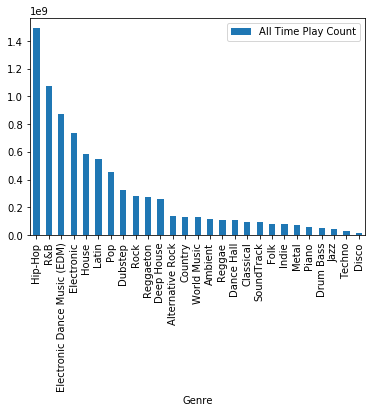

In [9]:
plt.figure(figsize=(100, 100))

df_allTimePlays.plot.bar(y='All Time Play Count')
plt.show()

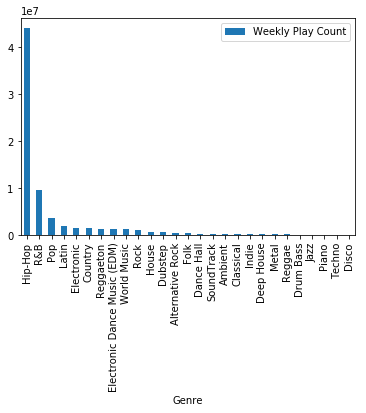

In [10]:
plt.figure(figsize=(100, 100))

df_weeklyPlays.plot.bar(y='Weekly Play Count')
plt.show()
